# 4.3 Analysis and Discovery - Phase III
Reading Pulitzer Final data, i.e., after wrangling and first clean up id done. At this stage, I plan to do an in-depth analysis to find relationship and outliers.

In [1]:
import itertools
from multiprocessing import Pool
import sys
import time
from cassandra.cluster import Cluster
from cassandra.concurrent import execute_concurrent_with_args
from cassandra.query import tuple_factory
from cassandra.auth import PlainTextAuthProvider


import pandas as pd
from google.cloud import storage
import datetime as dt
from datetime import datetime
from pytz import timezone
import uuid

In [4]:
df_con=pd.read_csv('~/connection_point.csv',header=0) #connection headers
df_code=pd.read_csv('~/states_code.txt',header=0,sep='\t') #US State Dict
states_dict=dict(zip(df_code.Abbreviation,df_code.State)) #Creating the dict

### 4.3.1 Reading the Pulitzer Final Data from Cassandra

In [5]:
from IPython.display import display
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

def _fetchData(query_):
    cluster = Cluster(contact_points=[df_con.ip[0]], auth_provider = \
                      PlainTextAuthProvider(username=df_con.user[0], \
                                            password=df_con.token[0]))
    session = cluster.connect()
    session.set_keyspace('capstone')
    session.row_factory = pandas_factory    
    rows = session.execute(query_)
    return rows

if __name__ == "__main__":
    query_pram="SELECT  Newspaper,state,DailyCirculation_2004, \
                DailyCirculation_2013,ChangeDailyCirculation_2004_2013,\
                WinNFinalists_1990_2003,WinNFinalists_2004_2014,WinNFinalists_1990_2014, \
                GDP_2004,GDP_2013,GDP_2014,crimeindex,violentcrime_2004,\
                violentcrime_2013,violentcrime_2014,popestimate2004, \
                popestimate2013,popestimate2014 FROM capstone.pulitzerFinal"                                
    rows = _fetchData(query_pram)
    df_pulitzer=rows._current_rows 

### 4.3.2 Data Transformation

Performing basic data tranformation for analysis.

In [6]:
inv_map = {v: k for k, v in states_dict.items()}
df_pulitzer.state=df_pulitzer.state.apply(lambda x:inv_map[x])

df_pulitzer['dailycirculation_2013']=df_pulitzer.dailycirculation_2013.apply(lambda x: x.replace(',',''))
df_pulitzer['dailycirculation_2004']=df_pulitzer.dailycirculation_2004.apply(lambda x: x.replace(',',''))

df_pulitzer['dailycirculation_2013']=df_pulitzer.dailycirculation_2013.apply(lambda x: float(x))
df_pulitzer['dailycirculation_2004']=df_pulitzer.dailycirculation_2004.apply(lambda x: float(x))

df_pulitzer['winnfinalists_1990_2003']=df_pulitzer.winnfinalists_1990_2003.apply(lambda x: float(x))
df_pulitzer['winnfinalists_2004_2014']=df_pulitzer.winnfinalists_2004_2014.apply(lambda x: float(x))
df_pulitzer['winnfinalists_1990_2014']=df_pulitzer.winnfinalists_1990_2014.apply(lambda x: float(x))

df_pulitzer['gdp_2004']=df_pulitzer.gdp_2004.apply(lambda x: float(x))
df_pulitzer['gdp_2013']=df_pulitzer.gdp_2013.apply(lambda x: float(x))
df_pulitzer['gdp_2014']=df_pulitzer.gdp_2014.apply(lambda x: float(x))

df_pulitzer['crimeindex']=df_pulitzer.crimeindex.apply(lambda x: float(x))

df_pulitzer['violentcrime_2004']=df_pulitzer.violentcrime_2004.apply(lambda x: float(x))
df_pulitzer['violentcrime_2013']=df_pulitzer.violentcrime_2013.apply(lambda x: float(x))
df_pulitzer['violentcrime_2014']=df_pulitzer.violentcrime_2014.apply(lambda x: float(x))

df_pulitzer['popestimate2004']=df_pulitzer.popestimate2004.apply(lambda x: float(x))
df_pulitzer['popestimate2013']=df_pulitzer.popestimate2013.apply(lambda x: float(x))
df_pulitzer['popestimate2014']=df_pulitzer.popestimate2014.apply(lambda x: float(x))

In [7]:
df_pulitzer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
newspaper                           50 non-null object
state                               50 non-null object
dailycirculation_2004               50 non-null float64
dailycirculation_2013               50 non-null float64
changedailycirculation_2004_2013    50 non-null object
winnfinalists_1990_2003             50 non-null float64
winnfinalists_2004_2014             50 non-null float64
winnfinalists_1990_2014             50 non-null float64
gdp_2004                            50 non-null float64
gdp_2013                            50 non-null float64
gdp_2014                            50 non-null float64
crimeindex                          50 non-null float64
violentcrime_2004                   50 non-null float64
violentcrime_2013                   50 non-null float64
violentcrime_2014                   50 non-null float64
popestimate2004                     50 non-null float64
pope

In [8]:
df_pulitzer.sample(7)

,newspaper,state,dailycirculation_2004,dailycirculation_2013,changedailycirculation_2004_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
29,Newark Star Ledger,New Jersey,395000.0,340778.0,-14%,2,6,8,424.0,531.0,542.0,1180.0,1360088.0,1168298.0,1165383.0,8925001.0,8661679.0,8677885.0
33,Minneapolis Star Tribune,Minnesota,377058.0,301345.0,-20%,4,4,8,231.0,304.0,316.0,1298.0,1360088.0,1168298.0,1165383.0,5453109.0,5163555.0,5207203.0
13,Baltimore Sun,Maryland,277947.0,177054.0,-36%,11,2,13,246.0,339.0,350.0,1884.0,1360088.0,1168298.0,1165383.0,5967295.0,5627367.0,5653408.0
40,St. Louis Post-Dispatch,Missouri,281198.0,167199.0,-41%,4,3,7,215.0,275.0,282.0,1858.0,1360088.0,1168298.0,1165383.0,6060930.0,5842704.0,5887612.0
36,Seattle Times,Washington,233497.0,229764.0,-2%,11,5,16,270.0,405.0,425.0,1855.0,1360088.0,1168298.0,1165383.0,7054196.0,6370753.0,6461587.0
7,Oregonian,Oregon,339169.0,228909.0,-33%,9,8,17,142.0,196.0,203.0,1497.0,1360088.0,1168298.0,1165383.0,3968371.0,3670883.0,3722417.0
5,Fort Woth Star-Telegram,Texas,237318.0,188593.0,-21%,1,0,1,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0


### 4.3.3 Analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

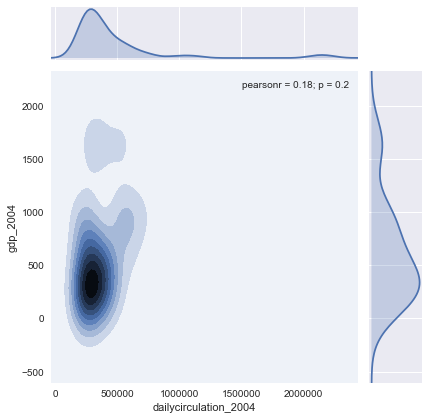

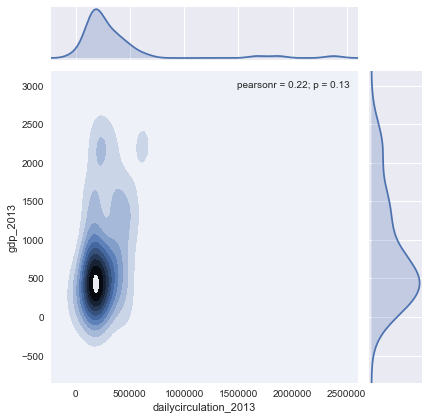

In [9]:
sns.jointplot(x='dailycirculation_2004',y='gdp_2004',data=df_pulitzer,kind='kde')
sns.jointplot(x='dailycirculation_2013',y='gdp_2013',data=df_pulitzer,kind='kde')
plt.show()

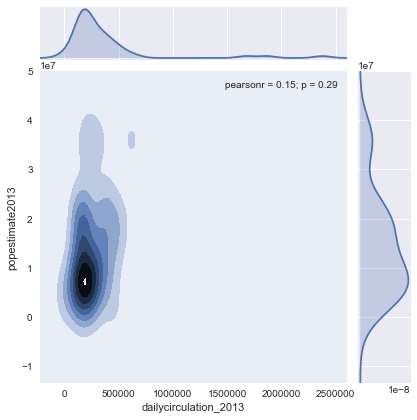

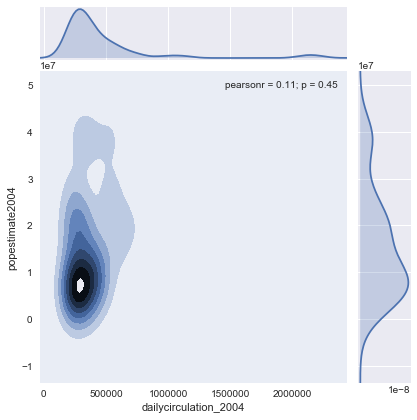

In [10]:
sns.jointplot(x='dailycirculation_2013',y='popestimate2013',data=df_pulitzer,kind='kde')
sns.jointplot(x='dailycirculation_2004',y='popestimate2004',data=df_pulitzer,kind='kde')
plt.show()

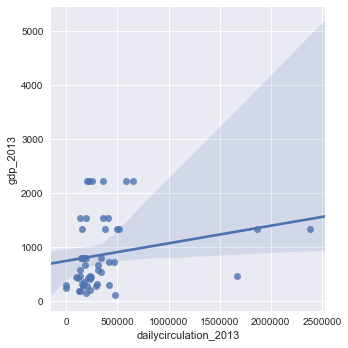

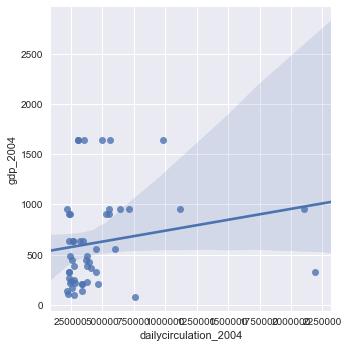

In [11]:
sns.lmplot(x='dailycirculation_2013',y='gdp_2013',data=df_pulitzer)
sns.lmplot(x='dailycirculation_2004',y='gdp_2004',data=df_pulitzer)
plt.show()

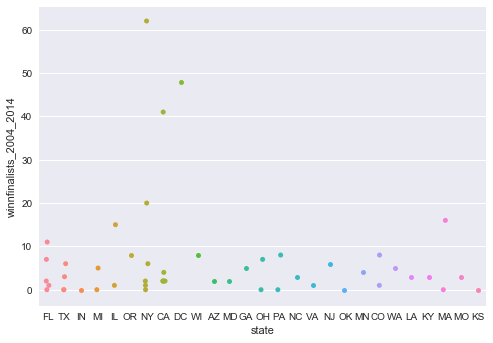

In [12]:
sns.stripplot(x='state',y='winnfinalists_2004_2014',data=df_pulitzer,jitter=True)
plt.show()

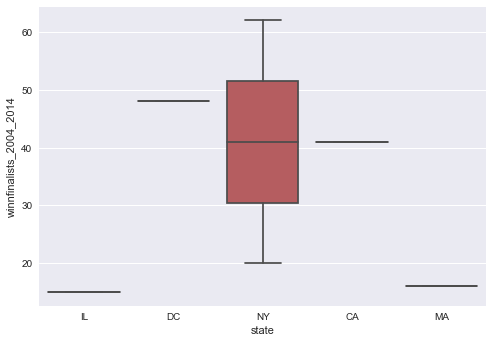

In [13]:
sns.boxplot(x='state',y='winnfinalists_2004_2014', \
            data=df_pulitzer[df_pulitzer.winnfinalists_2004_2014>=15])
plt.show()

In [14]:
df_pulitzer[(df_pulitzer.winnfinalists_2004_2014>=15) & (df_pulitzer.state=='DC')]

,newspaper,state,dailycirculation_2004,dailycirculation_2013,changedailycirculation_2004_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
10,Washington Post,DC,760034.0,474767.0,-38%,52.0,48.0,100.0,79.0,111.0,116.0,3747.0,1360088.0,1168298.0,1165383.0,659005.0,570681.0,574404.0


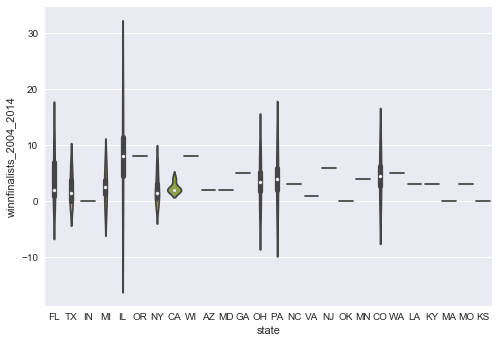

In [18]:
sns.violinplot(x='state',y='winnfinalists_2004_2014',data=df_pulitzer[df_pulitzer.winnfinalists_2004_2014<=15])

#sns.boxplot(x='state',y='winnfinalists_2004_2014', \
#            data=df_pulitzer[(df_pulitzer.winnfinalists_2004_2014<=15) & (df_pulitzer.state!=['CA','NY','DC'])])
plt.show()